<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Линейная регрессия</a></span><ul class="toc-item"><li><span><a href="#Визуальный-анализ" data-toc-modified-id="Визуальный-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Визуальный анализ</a></span></li><li><span><a href="#Регрессия" data-toc-modified-id="Регрессия-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Регрессия</a></span></li></ul></li></ul></div>

# Линейная регрессия

| Задание                            | Баллы          |
|------------------------------------|----------------|
| Анализ признаков и подготовка данных       |             15 |
| Корректность линейной регрессии    |             5 |

В файле auto.csv находятся данные, которые описывают характеристики 392 автомобилей. 

А именно, в данных вы найдете следующие столбцы:
1. mpg — расход топлива (миль/галлон);
2. cylinders — количество цилиндров мотора;
3. displacement — объем мотора (куб. дюйм);
4. horsepower — мощность мотора (в лошадиных силах);
5. weight — вес (тысяч фунтов);
6. acceleration — время, за которое автомобиль разгоняется до 60 mph; 
7. year — год автомобиля (по модулю 100);
8. origin — место производства (1 — Америка, 2 — Европа, 3 — Япония); 
9. name — название автомобиля.

Задания
- Визуально проанализируйте взаимосвязь между расходом топлива и остальными переменными
    - базовый код написан 
    - нужно проанализировать графики и прокомментировать наблюдения - обратите внимание на вопросы
    - по усмотрению можно сделать дополнительный анализ 
- Подготовьте данные для построения линейной регрессии
---
- Постройте линейную регрессионную модель для предсказания расхода топлива по этим данным
- Интерпретируйте значения коэффициентов регрессии (влияние каждого признака на отклик). 
    Какие признаки влияют на расход топлива и как?


## Визуальный анализ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)


In [2]:
import statsmodels.api as sm # все для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python

In [3]:
df = pd.read_csv('auto.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


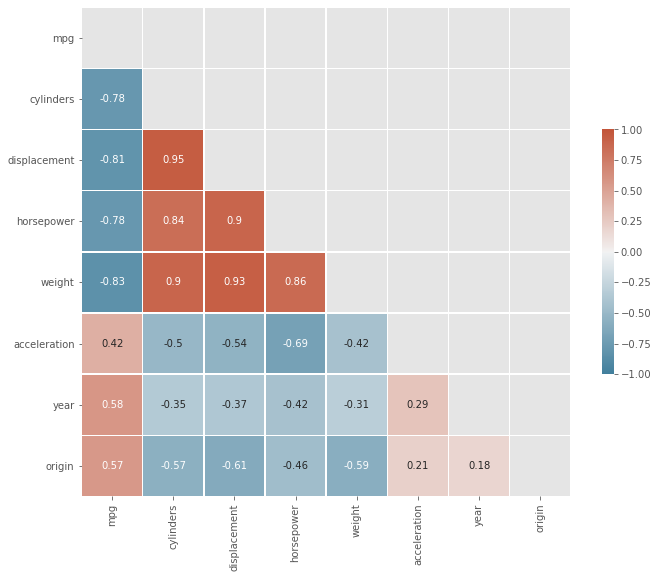

In [4]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

- Стоит ли использовать все признаки?

4 признака, с которыми mpg имеет сильную корреляцию, сильно коррелируют между собой: cylinders, displacement, horsepower, weight. Поэтому в уравнение регрессии скорее всего войдёт только один из них. Он же и составит основное значение коэффициента детерминации.

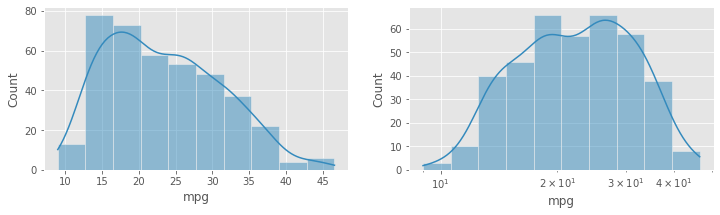

In [5]:
plt.figure(figsize=(12,3))
plt.subplot(121)
sns.histplot(df['mpg'], bins=10, kde=True)
plt.subplot(122)
sns.histplot(df['mpg'], bins=10, log_scale=True, kde=True);


- Нужно ли логарифмирование?

Визуально, логарифмирование не повышает качество распределения и даже снижает его, потому что появляется вторая мода. Поэтому лучше обойтись без преобразования.

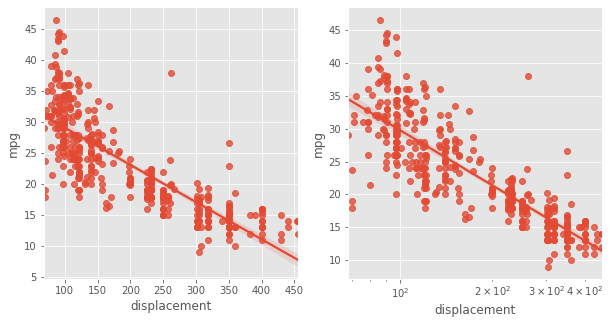

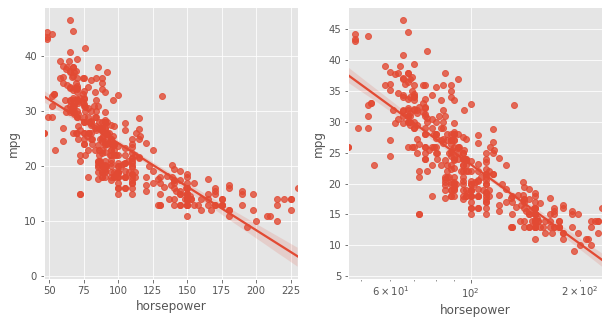

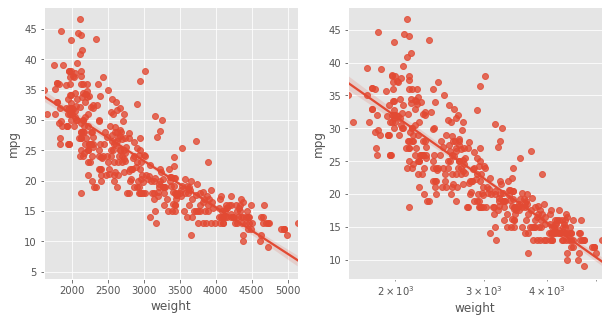

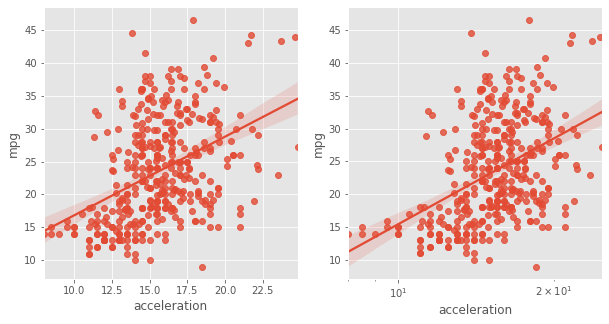

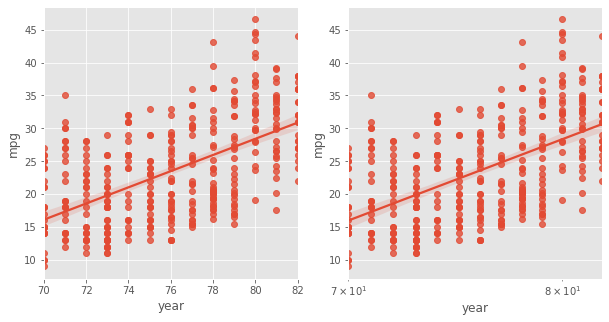

In [6]:
for x in ['displacement','horsepower','weight','acceleration','year']:
    plt.subplot(121)
    sns.regplot(data=df, x=x, y='mpg',  
#                 logx=True
               )
    plt.subplot(122)
    sns.regplot(data=df, x=x, y='mpg',  
                logx=True
               )
    plt.xscale('log')
    plt.show()

- Стоит ли попробовать логарифмировать некоторые признаки?

Да, horsepower и displacement.

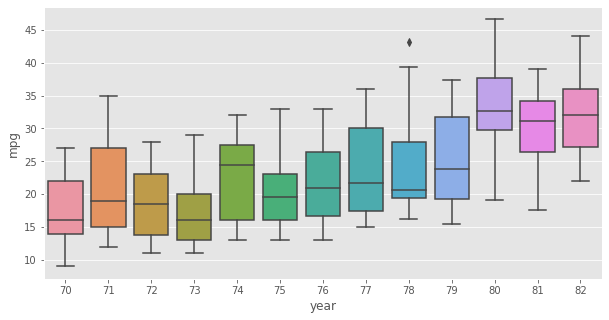

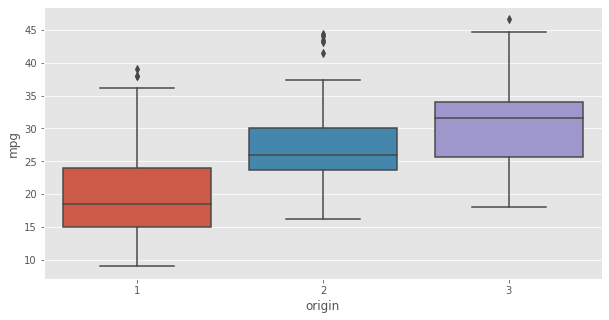

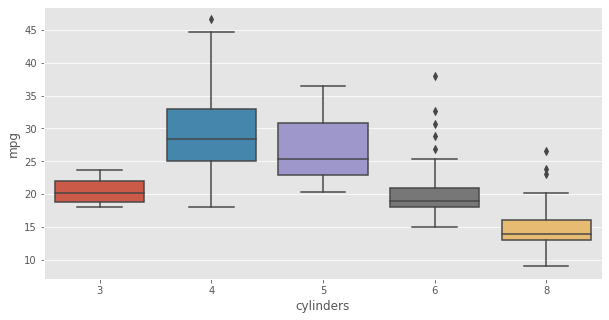

In [7]:
for x in ['year','origin','cylinders']:
    sns.boxplot(data=df, x=x, y='mpg');
    plt.show()

- Все ли признаки действительно числовые?

Нет, year и origin - чисто категориальные признаки. К тому же, origin лучше перекодировать с помощью one-hot encoding.


## Регрессия

In [8]:
import statsmodels.formula.api as smf

Построим парную регрессию с weight - с этим параметром у mpg максимальная корреляция.

In [9]:
model = smf.ols('mpg ~ weight', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     878.8
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          6.02e-102
Time:                        13:13:33   Log-Likelihood:                -1130.0
No. Observations:                 392   AIC:                             2264.
Df Residuals:                     390   BIC:                             2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.2165      0.799     57.867      0.0

Коэффициент детерминации для парной регрессии довольно высокий. Оценка веса параметра weight является значимой.
Однако низкое значение коэффициента Дарбина-Уотсона говорит об автокоррелированности ошибки. К тому же появилось предупреждение о возможной мультиколлинеарности.

In [10]:
df['ln_mpg'] = df['mpg'].apply(np.log1p)
df['ln_displacement'] = df['displacement'].apply(np.log1p)
df['ln_horsepower'] = df['horsepower'].apply(np.log1p)
# Логарифм от cylinders брать не будем, так как это дискретный признак.

In [11]:
model = smf.ols('ln_mpg ~ cylinders', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     834.5
Date:                Sat, 25 Feb 2023   Prob (F-statistic):           6.18e-99
Time:                        13:13:33   Log-Likelihood:                 109.72
No. Observations:                 392   AIC:                            -215.4
Df Residuals:                     390   BIC:                            -207.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0043      0.031    128.525      0.0

In [12]:
model = smf.ols('ln_mpg ~ ln_displacement', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     1105.
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          7.70e-116
Time:                        13:13:33   Log-Likelihood:                 148.80
No. Observations:                 392   AIC:                            -293.6
Df Residuals:                     390   BIC:                            -285.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.8502      0.082     

Коэффициент детерминации сильно вырос после логарифмирования. Также сразу упали AIC и BIC, а они чем меньше, тем лучше. 

In [13]:
model = smf.ols('ln_mpg ~ ln_horsepower', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1009.
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          3.09e-110
Time:                        13:13:34   Log-Likelihood:                 135.85
No. Observations:                 392   AIC:                            -267.7
Df Residuals:                     390   BIC:                            -259.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.8726      0.118     58.409

Формула ln_mpg ~ ln_horsepower обладает хорошим коэффициентом детерминации и значительно повышает статистику Дарбина-Уотсона.

Перекодируем столбец origin и применим к нему one-hot encoding.

In [14]:
df['origin_lit'] = df['origin'].map({1: 'Am', 2: 'Eu', 3: 'Ja'})
df = pd.get_dummies(df, columns=['origin_lit'], drop_first=True)

In [15]:
model = smf.ols('ln_mpg ~ ln_horsepower + origin_lit_Eu + origin_lit_Ja', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     391.2
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          6.52e-117
Time:                        13:13:34   Log-Likelihood:                 158.39
No. Observations:                 392   AIC:                            -308.8
Df Residuals:                     388   BIC:                            -292.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.4352      0.134     47.872

In [16]:
model = smf.ols('ln_mpg ~ ln_horsepower + origin_lit_Eu + origin_lit_Ja + acceleration', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     346.2
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          2.19e-126
Time:                        13:13:34   Log-Likelihood:                 183.63
No. Observations:                 392   AIC:                            -357.3
Df Residuals:                     387   BIC:                            -337.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7351      0.218     35.419

In [17]:
model = smf.ols('ln_mpg ~ ln_horsepower + origin_lit_Eu + origin_lit_Ja + acceleration + cylinders', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     306.3
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          6.27e-132
Time:                        13:13:34   Log-Likelihood:                 199.66
No. Observations:                 392   AIC:                            -387.3
Df Residuals:                     386   BIC:                            -363.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.0163      0.244     28.700

In [18]:
model = smf.ols('ln_mpg ~ ln_horsepower + origin_lit_Eu + origin_lit_Ja + acceleration + cylinders + year', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     417.1
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          5.04e-165
Time:                        13:13:34   Log-Likelihood:                 280.38
No. Observations:                 392   AIC:                            -546.8
Df Residuals:                     385   BIC:                            -519.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.6295      0.262     17.659

Включение year сильно увеличило коэффициент детерминации и статистику Дарбина-Уотсона, однако появилось предупреждение о мультиколлинеарности.

In [19]:
df[['ln_horsepower', 'origin_lit_Eu', 'origin_lit_Ja', 'acceleration', 'cylinders', 'year']].corr()

,ln_horsepower,origin_lit_Eu,origin_lit_Ja,acceleration,cylinders,year
ln_horsepower,1.000000,-0.307008,-0.339207,-0.698328,0.843519,-0.397374
origin_lit_Eu,-0.307008,1.000000,-0.230157,0.208298,-0.352324,-0.037745
origin_lit_Ja,-0.339207,-0.230157,1.000000,0.115020,-0.404209,0.199841
acceleration,-0.698328,0.208298,0.115020,1.000000,-0.504683,0.290316
cylinders,0.843519,-0.352324,-0.404209,-0.504683,1.000000,-0.345647
year,-0.397374,-0.037745,0.199841,0.290316,-0.345647,1.000000


Cylinders и acceleration имеют высокую корреляцию с ln_horsepower. К тому же acceleration при наличии ln_horsepower в модели меняет свой знак, что искажает интерпретацию этого признака. Исключим cylinders и acceleration модели.

In [20]:
model = smf.ols('ln_mpg ~ ln_horsepower + origin_lit_Eu + origin_lit_Ja + year', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_mpg   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     445.6
Date:                Sat, 25 Feb 2023   Prob (F-statistic):          2.24e-143
Time:                        13:13:35   Log-Likelihood:                 223.31
No. Observations:                 392   AIC:                            -436.6
Df Residuals:                     387   BIC:                            -416.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.8876      0.236     16.470

Год от года расход топлива уменьшается (mpg растёт). Конечно, это зависит не от времени, а от уровня развития технологий, но этого показателя у нас нет. Поэтому оставим year в модели.

**Проверим модель на автокореллированность и гетероскедастичность.**

`Durbin-Watson` в интервале [1;2] для больших выборок (> 100) означает отсутствие автокореллированности ошибки.

In [21]:
# Проверим гетероскедастичность.
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(res.resid, df[['ln_horsepower', 'origin_lit_Eu', 'origin_lit_Ja', 'year']].values)

(118.26711834674065,
 1.8223017632064795e-25,
 41.90914299497801,
 3.3012017831575213e-29)

Видим, что `pvalue` (последнее значение) сильно ниже уровня значимости. Гипотеза о гомоскедастичности отвергается. С гетероскедастичностью справиться не удалось. Вот, как она выглядит:

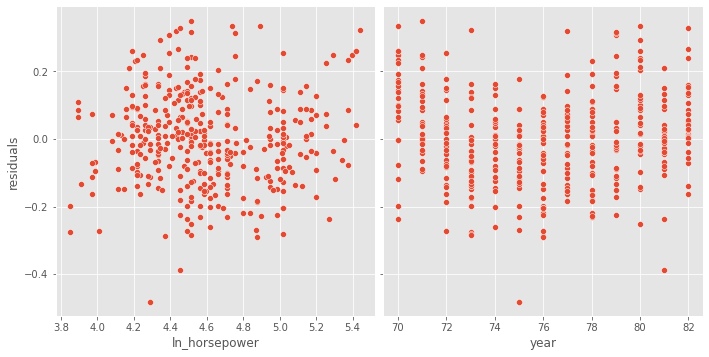

In [23]:
df['residuals'] = res.resid

sns.pairplot(
    df, 
    y_vars='residuals', 
    x_vars=['ln_horsepower', 'year'], 
    height=5,
    diag_kind=None
);

Сказать, чтобы ошибка увеличивалась при росте какого-либо параметра, наверное, нельзя.

**Проинтерпретируем коэффициенты регрессии.**
- Расход топлива: 
    - увеличивается (mpg снижается) на 0.6% при увеличении лошадиных сил на 1%;
    - ниже на 0.105%, если автомобиль произведён в Европе;
    - ниже на 0.16%, если автомобиль произведён в Японии;
    - снижается на 0.026% каждый год, взятый по модулю 100.